In [63]:
# uploading the data
import csv
import pandas as pd
import matplotlib.pyplot as plt
#open the first csv
GOOG_mess = pd.read_csv('GOOG_2012-06-21_34200000_57600000_message_5.csv', header=None)

# open the second csv
GOOG_ord = pd.read_csv('GOOG_2012-06-21_34200000_57600000_orderbook_5.csv', header=None)

# Concatenate the two csv
GOOG = pd.concat([GOOG_mess, GOOG_ord], axis=1)

GOOG.columns= ['Time', 'Type', 'Order ID', 'Size', 'Price', 'Direction', 'Ask Price 1', 'Ask Size 1', 'Bid Price 1', 'Bid Size 1', 'Ask Price 2', 'Ask Size 2', 'Bid Price 2', 'Bid Size 2','Ask Price 3', 'Ask Size 3', 'Bid Price 3', 'Bid Size 3','Ask Price 4', 'Ask Size 4', 'Bid Price 4', 'Bid Size 4','Ask Price 5', 'Ask Size 5', 'Bid Price 5', 'Bid Size 5']

In [64]:
#creation of new columns

# Midprice, Spread, Date Time

GOOG['Midprice']=(GOOG['Ask Price 1'] + GOOG['Bid Price 1']) / 2
GOOG['Spread']=(GOOG['Ask Price 1'] - GOOG['Bid Price 1'])
GOOG['Date_Time']= pd.to_datetime(GOOG['Time'], unit='s')


#Cumulative executed volume 

mask = (GOOG['Type'] == 4) | (GOOG['Type'] == 5)
selected_rows = GOOG[mask]
GOOG['Cumulative']=selected_rows['Size'].cumsum()
GOOG['Cumulative'].fillna(method='ffill', inplace=True)

#The difference between the best Bid Price and the 5th best Bid Price
GOOG['Diff']=(GOOG['Bid Price 1'] - GOOG['Bid Price 5'])

#Cancellation and deletion volume: 
mask2 = (GOOG['Type'] == 2) | (GOOG['Type'] == 3)
selected_rows2 = GOOG[mask2]
GOOG['Cumul_cancel']=selected_rows2['Size'].cumsum()
GOOG['Cumul_cancel'].fillna(method='ffill', inplace=True)

#Imbalance:
GOOG['Imbalance']=((GOOG['Bid Size 1'] - GOOG['Ask Size 1'])/((GOOG['Bid Size 1'] + GOOG['Ask Size 1'])))


In [65]:
#Physical time 

GOOG.set_index('Date_Time', inplace=True)
GOOG_resample = GOOG.resample('S').first()
GOOG_resample.dropna(subset=['Time'], inplace=True)
GOOG_resample['Time'] = GOOG_resample['Time'].astype(int)

In [66]:
# 10 sec MidPrice Return 
GOOG_resample['Mid_return'] = (GOOG_resample['Midprice'] - GOOG_resample['Midprice'].shift(10)) / GOOG_resample['Midprice'].shift(10)
GOOG_resample['Mid_return'].fillna(0, inplace=True)

#Executed Volume in the last 10 sec
GOOG_resample['10s Executed Vol'] = (GOOG_resample['Cumulative'] - GOOG_resample['Cumulative'].shift(10))

#Cancellation and deletion volumes in the last 10 sec
GOOG_resample['10s Cancel Vol'] = (GOOG_resample['Cumul_cancel'] - GOOG_resample['Cumul_cancel'].shift(10))

#volatility
window_size=30
GOOG_resample['Volatility'] = GOOG_resample['Price'].rolling(window=window_size).std()


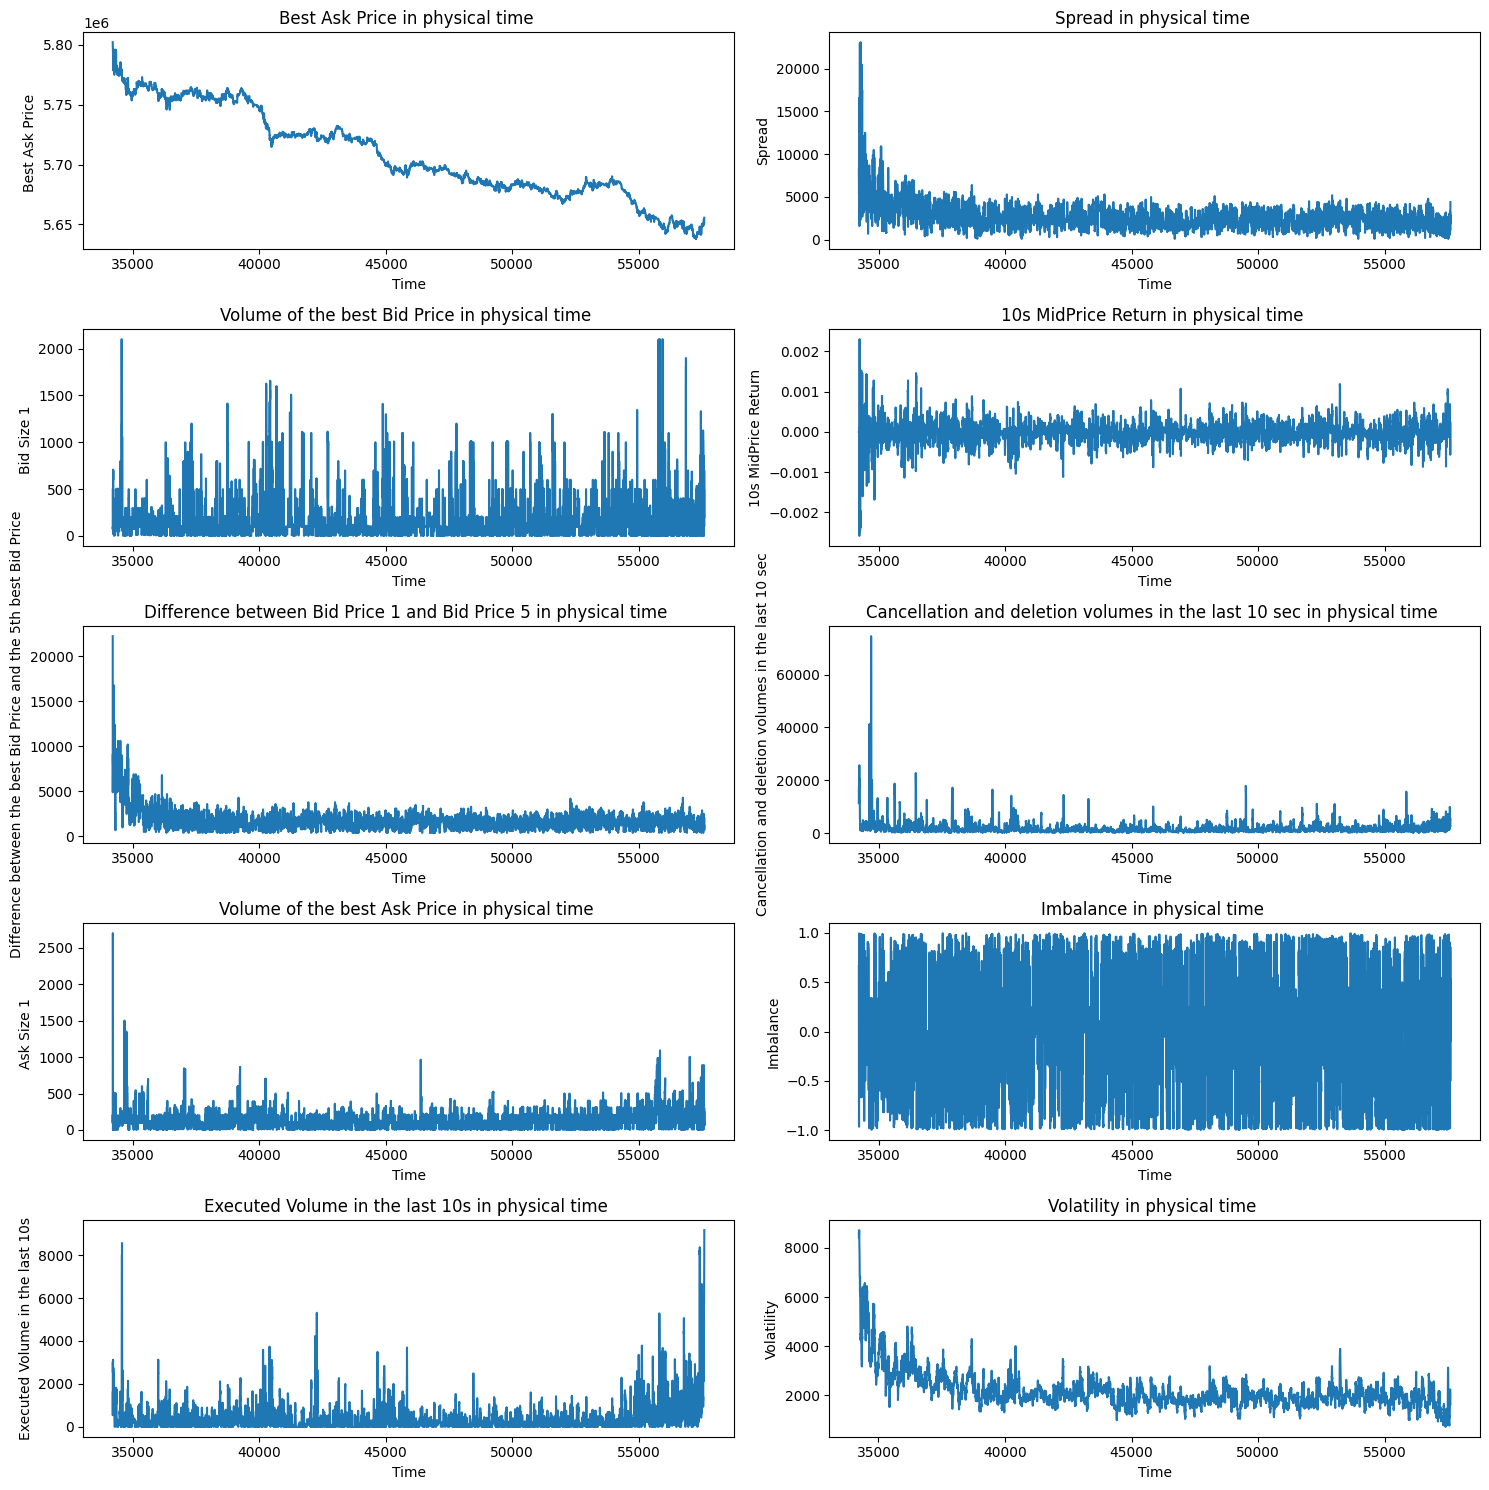

In [67]:

fig, axs = plt.subplots(5, 2,figsize=(15, 15))

for i in range(5):
    for j in range(2):
        axs[i,j].set_xlabel("Time")

axs[0,0].plot(GOOG_resample['Time'], GOOG_resample['Ask Price 1'], linestyle='-', marker='')
axs[0,0].set_title('Best Ask Price in physical time ')
axs[0,0].set_ylabel("Best Ask Price ")

axs[0,1].plot(GOOG_resample['Time'], GOOG_resample['Spread'], linestyle='-', marker='')
axs[0,1].set_title('Spread in physical time ')
axs[0,1].set_ylabel("Spread")

axs[3,0].plot(GOOG_resample['Time'], GOOG_resample['Ask Size 1'], linestyle='-', marker='')
axs[3,0].set_title('Volume of the best Ask Price in physical time ')
axs[3,0].set_ylabel("Ask Size 1 ")

axs[1,0].plot(GOOG_resample['Time'], GOOG_resample['Bid Size 1'], linestyle='-', marker='')
axs[1,0].set_title('Volume of the best Bid Price in physical time ')
axs[1,0].set_ylabel("Bid Size 1 ")

axs[1,1].plot(GOOG_resample['Time'], GOOG_resample['Mid_return'], linestyle='-', marker='')
axs[1,1].set_title('10s MidPrice Return in physical time ')
axs[1,1].set_ylabel("10s MidPrice Return")

axs[4,0].plot(GOOG_resample['Time'], GOOG_resample['10s Executed Vol'], linestyle='-', marker='')
axs[4,0].set_title('Executed Volume in the last 10s in physical time ')
axs[4,0].set_ylabel("Executed Volume in the last 10s")

axs[2,0].plot(GOOG_resample['Time'], GOOG_resample['Diff'], linestyle='-', marker='')
axs[2,0].set_title('Difference between Bid Price 1 and Bid Price 5 in physical time ')
axs[2,0].set_ylabel("Difference between the best Bid Price and the 5th best Bid Price")

axs[2,1].plot(GOOG_resample['Time'], GOOG_resample['10s Cancel Vol'], linestyle='-', marker='')
axs[2,1].set_title('Cancellation and deletion volumes in the last 10 sec in physical time ')
axs[2,1].set_ylabel("Cancellation and deletion volumes in the last 10 sec")

axs[3,1].plot(GOOG_resample['Time'], GOOG_resample['Imbalance'], linestyle='-', marker='')
axs[3,1].set_title('Imbalance in physical time ')
axs[3,1].set_ylabel("Imbalance")

axs[4,1].plot(GOOG_resample['Time'], GOOG_resample['Volatility'], linestyle='-', marker='')
axs[4,1].set_title('Volatility in physical time ')
axs[4,1].set_ylabel("Volatility")

plt.tight_layout()
plt.show()

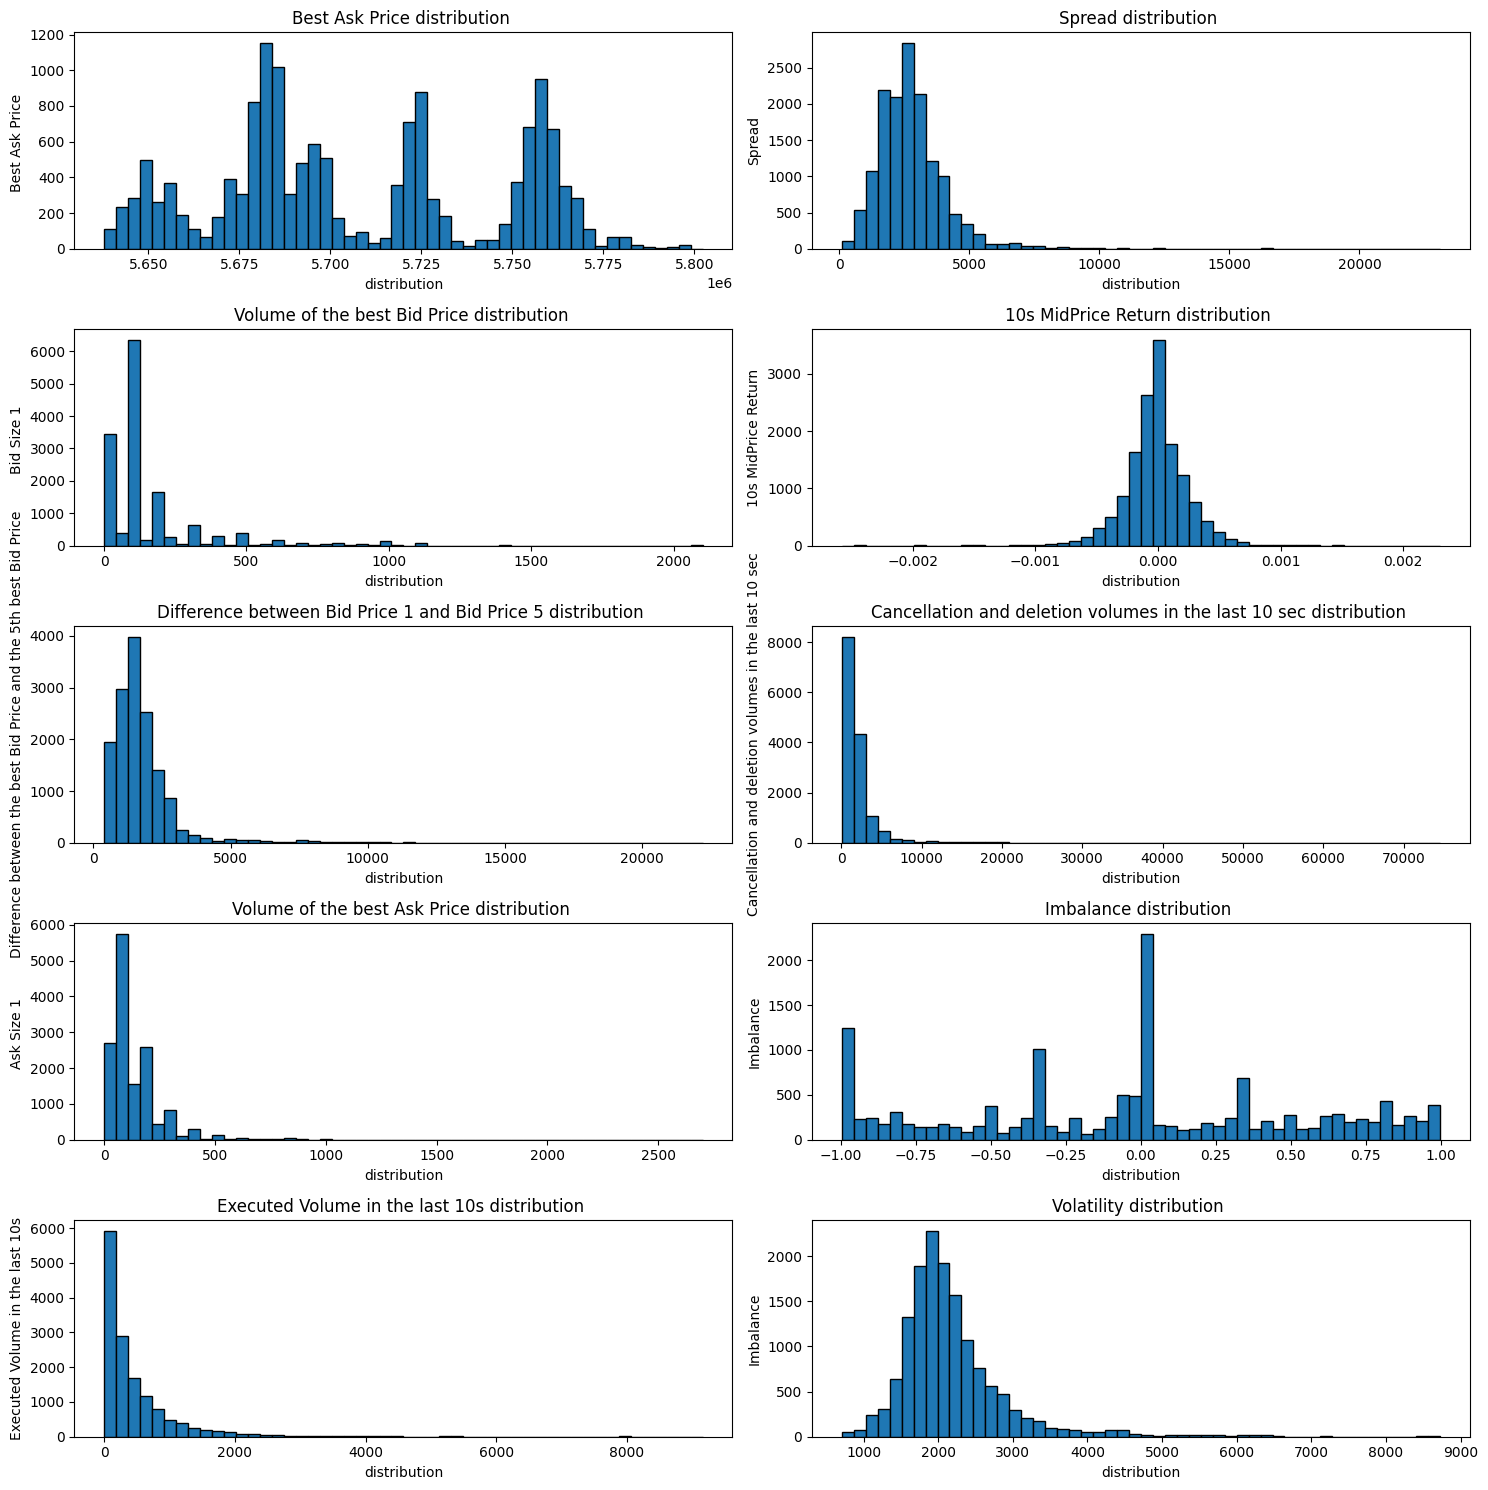

In [68]:

fig, axs = plt.subplots(5, 2,figsize=(15, 15))

for i in range(5):
    for j in range(2):
        axs[i,j].set_xlabel("distribution")


axs[0,0].hist(GOOG_resample['Ask Price 1'], bins=50, edgecolor='black')
axs[0,0].set_title('Best Ask Price distribution ')
axs[0,0].set_ylabel("Best Ask Price ")

axs[0,1].hist(GOOG_resample['Spread'], bins=50, edgecolor='black')
axs[0,1].set_title('Spread distribution ')
axs[0,1].set_ylabel("Spread")

axs[3,0].hist(GOOG_resample['Ask Size 1'], bins=50, edgecolor='black')
axs[3,0].set_title('Volume of the best Ask Price distribution ')
axs[3,0].set_ylabel("Ask Size 1 ")

axs[1,0].hist(GOOG_resample['Bid Size 1'], bins=50, edgecolor='black')
axs[1,0].set_title('Volume of the best Bid Price distribution ')
axs[1,0].set_ylabel("Bid Size 1 ")

axs[1,1].hist(GOOG_resample['Mid_return'], bins=50, edgecolor='black')
axs[1,1].set_title('10s MidPrice Return distribution ')
axs[1,1].set_ylabel("10s MidPrice Return")

axs[4,0].hist(GOOG_resample['10s Executed Vol'], bins=50, edgecolor='black')
axs[4,0].set_title('Executed Volume in the last 10s distribution ')
axs[4,0].set_ylabel("Executed Volume in the last 10s")

axs[2,0].hist(GOOG_resample['Diff'], bins=50, edgecolor='black')
axs[2,0].set_title('Difference between Bid Price 1 and Bid Price 5 distribution ')
axs[2,0].set_ylabel("Difference between the best Bid Price and the 5th best Bid Price")

axs[2,1].hist(GOOG_resample['10s Cancel Vol'], bins=50, edgecolor='black')
axs[2,1].set_title('Cancellation and deletion volumes in the last 10 sec distribution ')
axs[2,1].set_ylabel("Cancellation and deletion volumes in the last 10 sec")

axs[3,1].hist(GOOG_resample['Imbalance'], bins=50, edgecolor='black')
axs[3,1].set_title('Imbalance distribution ')
axs[3,1].set_ylabel("Imbalance")

axs[4,1].hist(GOOG_resample['Volatility'], bins=50, edgecolor='black')
axs[4,1].set_title('Volatility distribution ')
axs[4,1].set_ylabel("Imbalance")



plt.tight_layout()
plt.show()